<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/seminar_13_kernel_density_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bandwidth and kenel influence on 1D KDE

In [0]:
# install KDEpy library before starting the following demo
!pip install KDEpy

In [0]:
#@title Bandwidth and kernel in KDE
from google.colab import widgets
import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import LeaveOneOut #train_test_split
from KDEpy import FFTKDE


params = []
X = []
b_w = ipywidgets.FloatSlider(description='bandwidth', min=1, max=50.0, value=15.0)
ker_type = ipywidgets.Dropdown(
  options=['gaussian', 'tophat', 'epanechnikov', 'exponential','linear','cosine'],
  value='gaussian',
  description='Kernel:',
  disabled=False)

def set_slider(x):
  bandwidths = np.linspace(b_w.min, b_w.max, 100)
  loo = LeaveOneOut()
  grid = GridSearchCV(KernelDensity(kernel=ker_type.value), {'bandwidth': bandwidths}, cv=loo)
  grid.fit(np.array(X)[:, None]);
  b_w.value = grid.best_params_['bandwidth']

def set_slider2(x):
  ker = {'gaussian':'gaussian', 'cosine':'cosine', 
         'tophat':'box', 'epanechnikov':'epa', 
         'exponential':'exponential', 'linear':'tri'}
  kde = FFTKDE(bw='ISJ', kernel=ker[ker_type.value])
  kde.fit(X)(None)
  b_w.value = kde.bw

def set_slider1(x):
  #std = np.sqrt(np.var(X, axis=0))
  #silverman = ((4/(3* len(np.array(X)[:, None])))*std**5)**(1/5)
  #b_w.value = silverman

  ker = {'gaussian':'gaussian', 'cosine':'cosine', 
         'tophat':'box', 'epanechnikov':'epa', 
         'exponential':'exponential', 'linear':'tri'}
  kde = FFTKDE(bw='silverman', kernel=ker[ker_type.value])
  kde.fit(X)(None)
  b_w.value = kde.bw

def plot_pdf(plot_separate, k_d = None):
  global params
  global X
  if not params:
    return

  pi1, pi2, pi3, mu1, sig1, mu2, sig2, mu3, sig3 = params
  x = np.linspace(np.min(X), np.max(X), 1001)
  fig = plt.figure(figsize=(10, 8))
  P_sum = np.zeros(x.shape)
  for mu, sig, c, pi, i in [[mu1, sig1, 'r', pi1, 1], [mu2, sig2, 'g', pi2, 2], [mu3, sig3, 'b', pi3, 3]]:
    P = scipy.stats.norm.pdf(x, mu, sig)
    P_sum += P * pi
    if plot_separate:
      plt.plot(x, P, c, linewidth=2.0, label="{}".format(i), alpha=np.clip(pi, 0.0, 1.0))
  
  plt.plot(x, P_sum, 'k', linewidth=3.0, label="mixture")
  plt.plot(np.array(X), np.full_like(np.array(X), 0.0), '|k', markeredgewidth=1)
  plt.title('True pdf / pdf estimate')
  plt.xlabel('x')
  plt.ylabel('pdf')
  plt.legend()
  #plt.show()

def set_and_plot(pi, mu1, sig1, mu2, sig2, mu3, sig3):
  pi1, pi2 = pi; pi2 -= pi1; pi3 = 1.0 - pi2 - pi1;
  global params
  global X
  X = []
  params = [pi1, pi2, pi3, mu1, sig1, mu2, sig2, mu3, sig3]
  N = 200
  for mu, sig, pi in [[mu1, sig1, pi1], [mu2, sig2, pi2], [mu3, sig3, pi3]]:
    X = X + np.random.normal(mu, sig, int(N * pi)).tolist()
  plot_pdf(True)


def ker_plot(b_w, k_t):
  kde = KernelDensity(bandwidth=b_w, kernel=k_t)
  global X
  kde.fit(np.array(X)[:, None])
  x_d = np.linspace(np.min(X), np.max(X), 1001)
  logprob = kde.score_samples(x_d[:, None])
  plot_pdf(False)
  plt.fill_between(x_d, np.exp(logprob), alpha=0.5, color='r')

tb = widgets.TabBar(['mix distribution', 'find KDE'], location='top')
with tb.output_to(0):
  words = ['mu_1', 'sigma_1', 'mu_2', 'sigma_2', 'mu_3', 'sigma_3']
  mins  = [0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
  maxes = [100.0, 10.0, 100.0, 10.0, 100.0, 10.0]
  vals  = [10.0, 10.0, 50.0, 10.0, 90.0, 10.0]
  sliders = [ipywidgets.FloatSlider(description=w, min=n, max=x, value=v) for w,x,n,v in zip(words, maxes, mins, vals)]
  pi_slider = ipywidgets.FloatRangeSlider(value=[0.3, 0.6], min=0.0, max=1.0, description='pi(1,2,3)')
  boxes = [ipywidgets.VBox([pi_slider])]
  for slider1, slider2 in zip(sliders[::2], sliders[1::2]):
    boxes.append(ipywidgets.VBox([slider1, slider2]))
  out = ipywidgets.interactive_output(set_and_plot, {
    "pi": pi_slider,
    "mu1": sliders[0], "sig1": sliders[1],
    "mu2": sliders[2], "sig2": sliders[3],
    "mu3": sliders[4], "sig3": sliders[5]})
  display(ipywidgets.HBox(boxes), out)
with tb.output_to(1):
  btn = ipywidgets.Button(
    description='Cross Validation',
    disabled=False,
    button_style='')
  btn1 = ipywidgets.Button(
    description='Silverman',
    disabled=False,
    button_style='')
  btn2 = ipywidgets.Button(
    description='ISJ',
    disabled=False,
    button_style='')
  out = ipywidgets.interactive_output(ker_plot, {"b_w": b_w, "k_t": ker_type})
  display(ipywidgets.HBox([ker_type, ipywidgets.VBox([b_w, ipywidgets.HBox([btn1, btn2, btn])])]), out)
  btn.on_click(set_slider)
  btn1.on_click(set_slider1)
  btn2.on_click(set_slider2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Output()

<IPython.core.display.Javascript object>

#KDE in 2D (kernel, bandwidth, sample, metric)

In [0]:
from sklearn.neighbors import KernelDensity
# instantiate and fit the KDE model
kde = KernelDensity()

def fit_distribution(X, bandwidth, ker_name, metric_name):
  params = {'bandwidth': bandwidth, 'kernel': ker_name, 'metric': metric_name}
  kde.set_params(**params)
  kde.fit(X)

def evaluate_distribution(X):
  logprob = kde.score_samples(X)
  return np.exp(logprob)

In [0]:
#@title Interactive 2D KDE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
import seaborn as sns
        
def plot_clusters(x_, y_, z_):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  #ax = sns.kdeplot(X[:,0], X[:,1], cmap="Blues", shade=True, shade_lowest=False)
  sns.set()
  ax.contourf(x_, y_, z_, alpha=0.5, cmap="Blues")
  ax.tick_params(axis="y",direction="in", pad=-60)
  ax.tick_params(axis="x",direction="in", pad=-30)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  ax.set_xlim([-1, 1])
  ax.set_ylim([-1, 1])

  plt.close(fig)
  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64



import json
from IPython.display import display, clear_output

def invoke(pts, n, ker_name, metric_name):
  data = np.array(pts).reshape((-1, 2))
  X = data / 300.0 - 1.0
  X[:, 1] *= -1.0
  fit_distribution(X, float(n)/1000.0, ker_name, metric_name)
  x_ = np.linspace(-1.0, +1.0, num=300)
  y_ = np.linspace(-1.0, +1.0, num=300)
  xx, yy = np.meshgrid(x_, y_)
  x_vec = np.transpose(np.vstack([xx.ravel(), yy.ravel()]))
  G  = evaluate_distribution(x_vec).reshape((x_.shape[0],y_.shape[0]))
  figr = plot_clusters(x_, y_, G)
  image_base64 = figure_to_base64(figr)

  return IPython.display.JSON({'image': image_base64, 
                               'g_x': x_.tolist(), 'g_y': y_.tolist(), 'g_z': G.tolist(),
                               's_x': X[:, 0].tolist(), 's_y': X[:, 1].tolist(), 's_z': [0]*len(X)})


import IPython
from google.colab import output

main_str = '''
  <script src="https://cdn.plot.ly/plotly-latest.min.js"></script> 
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var classAbtn = [650, 100];
    var classBbtn = [650, 200];
    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = 'rgba(255, 128, 0, 0.5)';
      ctx.fill();
    }
    
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field
        
        ctx.font = '20px serif';
        ctx.fillStyle = 'black';
        ctx.fillText(debug_txt, 200, 200);
        
        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]]);
        });

      }
    }
    
    var timer

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state == "add") {
        if (x < 600)
            all_pts.push([x, y]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      evt.stopPropagation();
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      evt.stopPropagation();
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }


   function plot_3d(g_x, g_y, g_z)
   {
     cell_for_plot = document.getElementById('for_plotly_plot');
     //Plotly.deleteTraces(cell_for_plot, [0, 1]);
     var data = [{
           x: g_x,
           y: g_y,
           z: g_z,
           type: 'surface',
           opacity: 0.9,
           showscale: false,
           colorscale: "Viridis"
        }];
  
     var layout = {
          title: 'pdf estimate',
          autosize: false,
          width: 600,
          height: 600,
          showlegend: false,
          scene: {
            camera: {
              up: {x: 0, y: 1, z: 0},
              center: {x: 0, y: 0, z: 0},
              eye: {x: 0.0, y: -1.0, z: 1.4}
            }
          }
        };
     Plotly.newPlot(cell_for_plot, data, layout);
   }

   function plot_scatter(s_x, s_y, s_z)
   {
          
     cell_for_plot = document.getElementById('for_plotly_plot');
     var data = [{
           x: s_x,
           y: s_y,
           z: s_z,
           type: 'scatter3d',
           mode: 'markers',
           marker: {
             size: 4,
             colorscale: "Viridis",
             line: {
               width: 2,
               color: 'rgba(0, 0, 0, 0.5)'
             }
           }
        }];
    Plotly.plot(cell_for_plot, data, {});
   }


    var cur_depth = 100;

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      var e = document.getElementById("select_kernel");
      var ker_name = e.options[e.selectedIndex].value;
      var e1 = document.getElementById("select_metric");
      var metric_name = e1.options[e1.selectedIndex].value;
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged, cur_depth, ker_name, metric_name], {});
      params = result.data['application/json'];
            
      bg_image.src = 'data:image/  png;base64,' + params.image;
      cell_for_plot = document.getElementById('for_plotly_plot');
      
      plot_3d(params.g_x, params.g_y, params.g_z);
      plot_scatter(params.s_x, params.s_y, params.s_z);
      
    }

   function h_change(x) {
    el = document.getElementById("slider_val");
    cur_depth = x;
    el.innerHTML = x;
  }

 </script>

<div id="everything" style="height:600px;">
<div id="for_plotly_plot" style="position:absolute; top:0px; left:0px; height:600px; width:600px;">
</div>
<div id="custom_controls" style="position:absolute; top:0px; left:600px;">
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:200px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1" name="rate" value="add" checked="checked"> Add Feature
    <br>
    <input type="radio" id="r2" name="rate" value="move"> Move Features
    <br>
    <input type="radio" id="r3" name="rate" value="del"> Delete Feature
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>Bandwidth x 1000:<br>
    <input type="range" min="1" max="200" value="100" oninput="h_change(this.value)">
    <br><div id="slider_val">100</div>
   <br>Kernel:<br>
   <select id="select_kernel">
       <option value="gaussian">gaussian</option>
       <option value="tophat">tophat</option>
       <option value="epanechnikov">epanechnikov</option>
       <option value="exponential">exponential</option>
       <option value="linear">linear</option>
       <option value="cosine">cosine</option>
   </select>
   <br>
   Metric:
   <br>
   <select id="select_metric">
       <option value="euclidean">euclidean</option>
       <option value="manhattan">manhattan</option>
       <option value="infinity">infinity</option>
   </select>
   <br><br>
    <button type="button" onclick="calculate();">
      KDE
    </button>
  </div>
</div>
<div>
  
<script>
function init()
{
  timer = setInterval(draw, 10);
}

init();
</script>
'''

display(IPython.display.HTML(main_str))
output.register_callback('notebook.InvSVM', invoke)

#1849 Broad Street cholera outbreak visualization

The Broad Street cholera outbreak was a severe outbreak of cholera that occurred in 1854 near Broad Street (now Broadwick Street) in the Soho district of the City of Westminster, London, England, and occurred during the 1846–1860 cholera pandemic happening worldwide. This outbreak, which killed 616 people, is best known for the physician John Snow's study of its causes and his hypothesis that germ-contaminated water was the source of cholera, rather than particles in the air.This discovery came to influence public health and the construction of improved sanitation facilities beginning in the mid-19th century.


![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_13/snows.png) 

On 31 August 1854, after several other outbreaks had occurred elsewhere in the city, a major outbreak of cholera occurred in Soho. Snow, the physician who eventually linked the outbreak to contaminated water, later called it "the most terrible outbreak of cholera which ever occurred in this kingdom."

Over the next three days, 127 people on or near Broad Street died. During the next week, three quarters of the residents had fled the area. By 10 September, 500 people had died and the mortality rate was 12.8 percent in some parts of the city. By the end of the outbreak, 616 people had died.

Many of the victims were taken to the Middlesex Hospital, where their treatment was superintended by Florence Nightingale (we've talked about here in statistics lecture), who briefly joined the hospital in early September in order to help with the outbreak. 

By talking to local residents Snow identified the source of the outbreak as the public water pump on Broad Street. Although Snow's chemical and microscope examination of a sample of the water from this Broad Street pump water did not conclusively prove its danger, his facts about the patterns of illness and death among residents in Soho persuaded the St James parish authorities to disable the well pump by removing its handle.

It's worth mentioning that the germ theory was not established at this point (Louis Pasteur did not propose it until 1861). Snow did not understand the mechanism by which disease was transmitted, but the evidence led him to believe that it was NOT due to breathing foul air. Based on the pattern of illness among residents, Snow hypothesized that cholera was spread by an agent in contaminated water. He first published his theory in 1849, in an essay titled "On the Mode of Communication of Cholera".

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_13/mapsnow.png) 

**Preparation**

Download the dataset in a `csv` format from github.
Following code should do the job.

In [2]:
# download the dataset
!wget https://raw.githubusercontent.com/fbeilstein/machine_learning/master/datasets/pumps.csv
!wget https://raw.githubusercontent.com/fbeilstein/machine_learning/master/datasets/deaths.csv
!wget https://raw.githubusercontent.com/fbeilstein/machine_learning/master/datasets/cholera_map.jpg

--2019-12-10 20:09:18--  https://raw.githubusercontent.com/fbeilstein/machine_learning/master/datasets/pumps.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118 [text/plain]
Saving to: ‘pumps.csv’

pumps.csv           100%[===================>]     118  --.-KB/s    in 0s      

2019-12-10 20:09:19 (16.3 MB/s) - ‘pumps.csv’ saved [118/118]

--2019-12-10 20:09:22--  https://raw.githubusercontent.com/fbeilstein/machine_learning/master/datasets/deaths.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4811 (4.7K) [text/plain]
Saving to: ‘d

The files you have downloaded contain the following information
* `pumps.csv` -- coordinates of pumps (sources of water), contains $2$ columns, namely `x` and `y`
* `deaths.csv` -- coordinates of households, where anyone had died from cholera. Points can repeat if few deaths in one house were spotted.
* `cholera_map.jpg` -- map of London. Coordinates in other files correspond to pixels in this image.

**Problem 1:**
complete the `read_dataframe(filename)` function so that it takes name of the file and returns pandas.dataframe

In [0]:
import pandas as pd

def read_dataframe(filename):
  # ENTER YOUR CODE HERE
  return pd.read_csv(filename)

Use the following code to visualize tables.

In [9]:
#@title Visualize table
from google.colab import data_table
from google.colab import widgets

tb = widgets.TabBar(['pumps.csv', 'deaths.csv'], location='top')
with tb.output_to(0):
  display(data_table.DataTable(read_dataframe('pumps.csv'), include_index=False, num_rows_per_page=10))
with tb.output_to(1):
  display(data_table.DataTable(read_dataframe('deaths.csv'), include_index=False, num_rows_per_page=10))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,x,y
0,1698,1288
1,1032,1082
2,1016,700
3,2849,1667
4,2398,1742
5,1863,1958
6,2306,2528
7,1340,2044
8,1022,160
9,1448,59


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,x,y
0,1409,1257
1,1409,1257
2,1409,1257
3,1420,1278
4,1420,1278
...,...,...
484,1612,781
485,1612,781
486,1281,1666
487,1360,1783


<IPython.core.display.Javascript object>

**Problem 2:**
Visualize `cholera_map.jpg` with matplotlib.
Complete the following function so that it plots the map.
You can use `imread` and `imshow` functions.

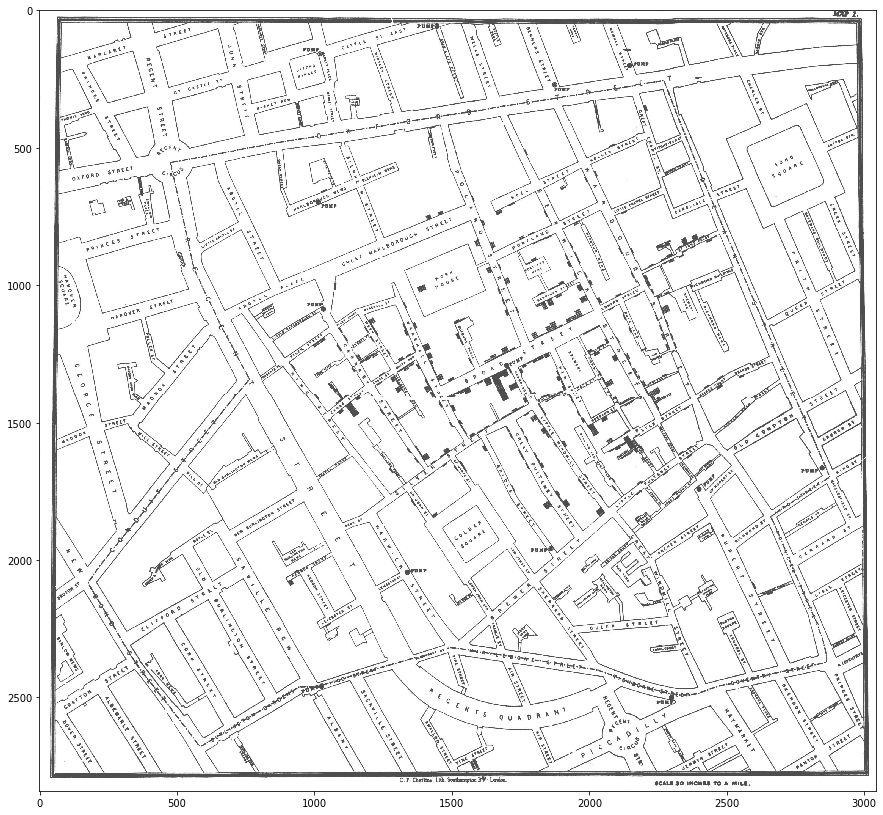

In [11]:
import matplotlib.pyplot as plt

def plot_map(filename):
  # ENTER YOUR CODE HERE
  cholera_map = plt.imread(filename)
  plt.imshow(cholera_map, alpha=0.7);

plt.figure(figsize=(15, 15));
plot_map('cholera_map.jpg')

**Problem 3:**
Visualize points from given dataframe as a scatter plot.
Suppose that dataframe contains two columns `x` and `y`.
Use parameter `color` to set the color of points.

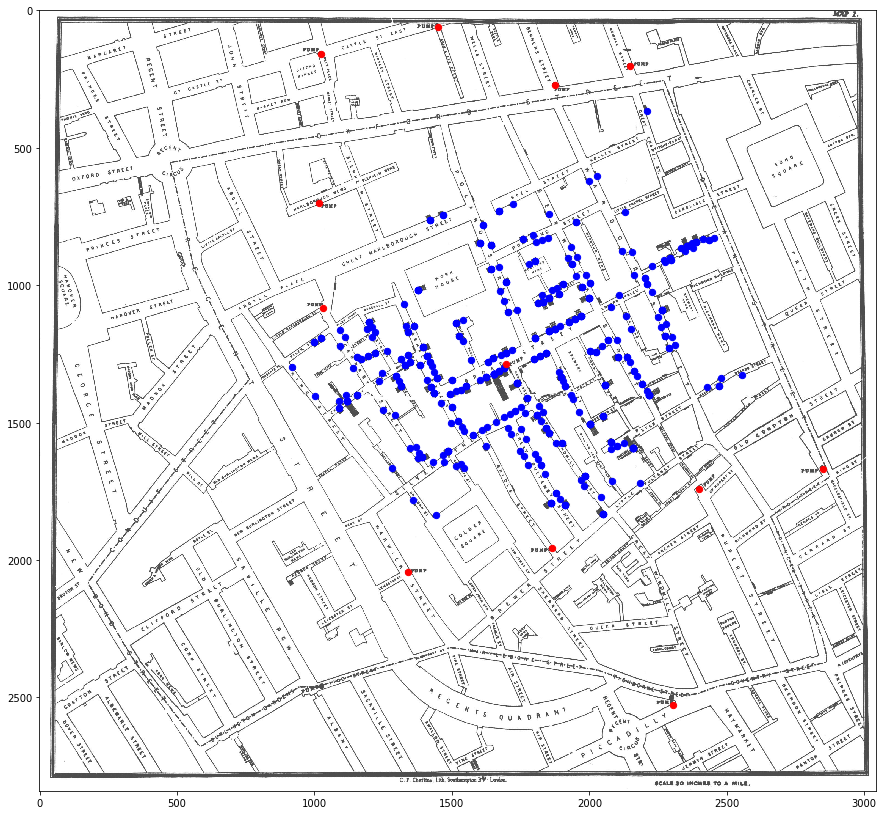

In [15]:
def plot_points(dataframe, color):
  # ENTER YOUR CODE HERE
  plt.scatter(x=dataframe['x'], y=dataframe['y'], c=color, s=40);

plt.figure(figsize=(15, 15));
plot_map('cholera_map.jpg')
plot_points(read_dataframe('deaths.csv'), 'b')
plot_points(read_dataframe('pumps.csv'), 'r')

**Problem 4:**
Visualize points from the dataframe given as a kernel density.
For better visuals tune opacity (e.g. set `alpha=0.8`).
You may suppose that dataframe contains columns `x` and `y`.

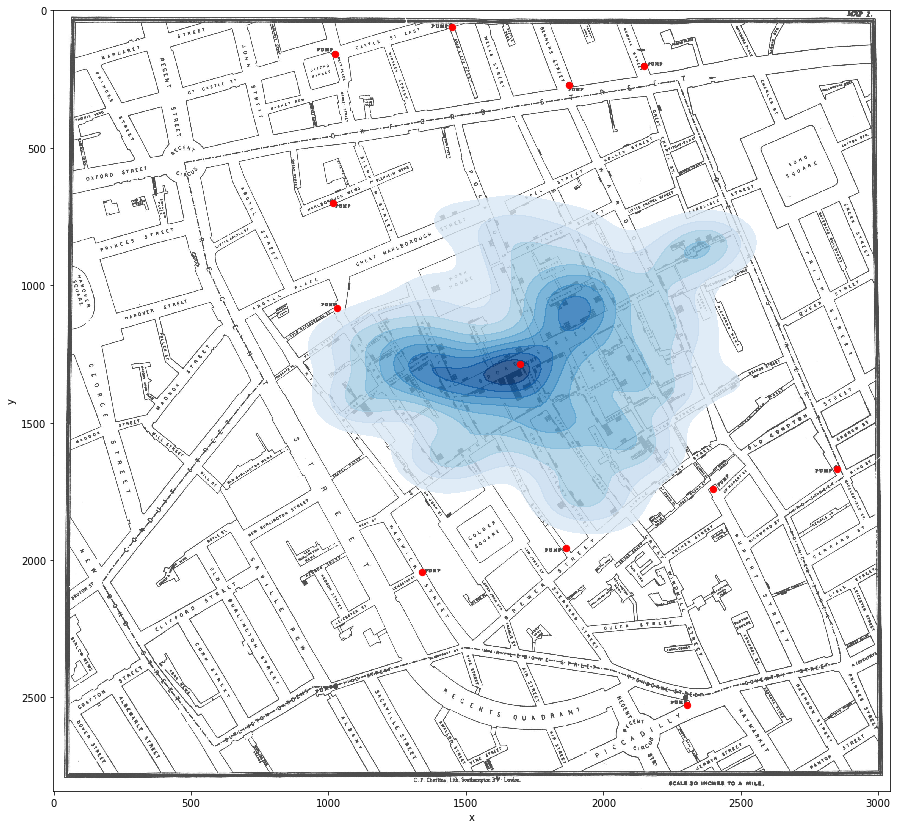

In [16]:
import seaborn as sns

def plot_kde(dataframe):
  # ENTER YOUR CODE HERE
  sns.kdeplot(dataframe['x'], dataframe['y'], cmap="Blues", shade=True, shade_lowest=False, alpha=0.8);

plt.figure(figsize=(15, 15));
plot_map('cholera_map.jpg')
plot_kde(read_dataframe('deaths.csv'))
plot_points(read_dataframe('pumps.csv'), 'r')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

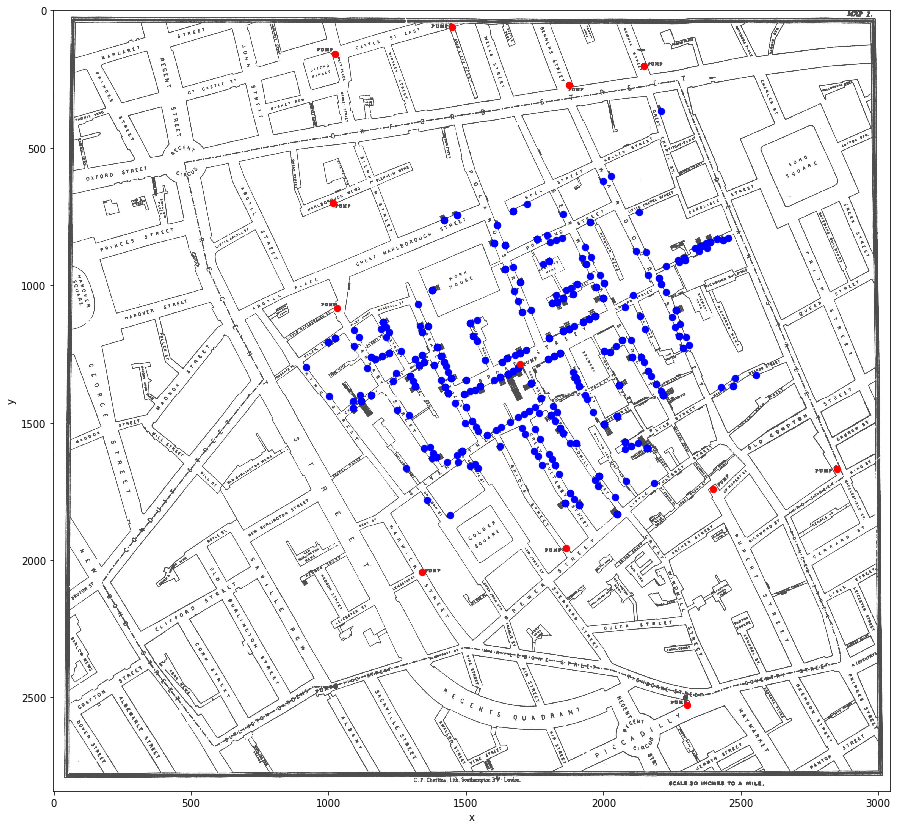

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

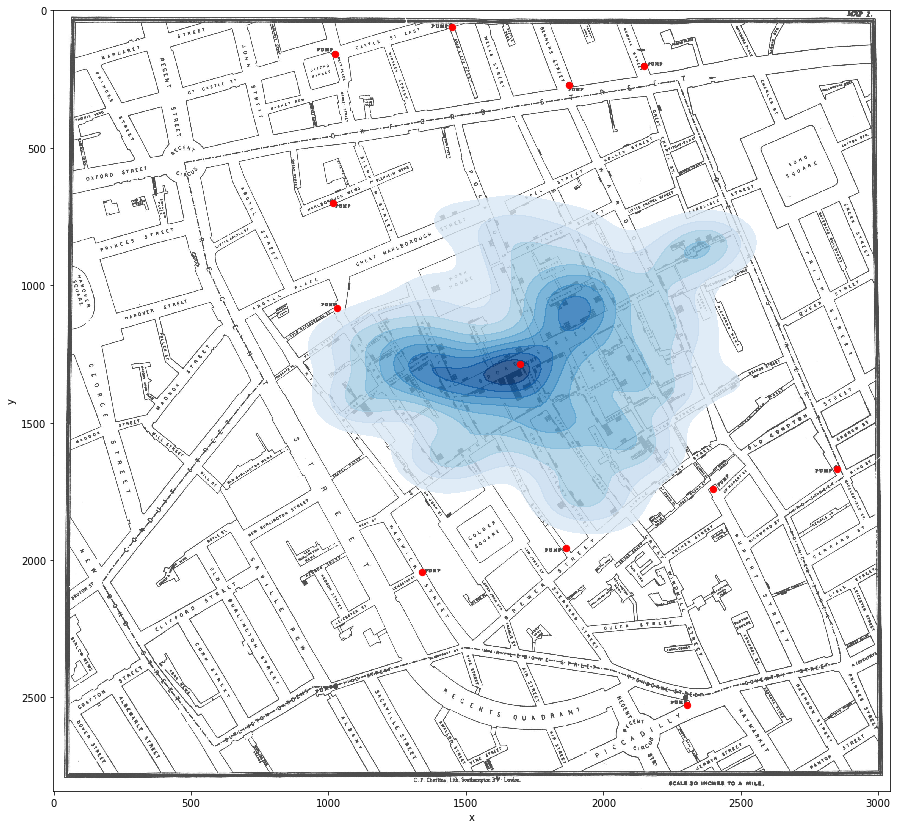

<IPython.core.display.Javascript object>

In [22]:
#@title Visualize both
from google.colab import widgets

tb = widgets.TabBar(['Scatter', 'KDE'], location='top')
with tb.output_to(0):
  plt.figure(figsize=(15, 15));
  plot_map('cholera_map.jpg')
  plot_points(read_dataframe('deaths.csv'), 'b')
  plot_points(read_dataframe('pumps.csv'), 'r')
  plt.ylabel('y')
  plt.xlabel('x')
with tb.output_to(1):
  plt.figure(figsize=(15, 15));
  plot_map('cholera_map.jpg')
  plot_kde(read_dataframe('deaths.csv'))
  plot_points(read_dataframe('pumps.csv'), 'r')
  plt.ylabel('y')
  plt.xlabel('x')